In [1]:
import sys, numpy as np, matplotlib.pyplot as plt

# # first time you run the script you will probably need to install these modules:
# ! pip install vg
# ! pip install pytransform3d

In [2]:
def hexagon_diameter_to_coordinates(d, x_spacing=10.5/1000, y_spacing=9/1000) -> list((float, float, float)):
    
    """
    
    Coordinate system for d-transducers diameter hexagon. Centrepoint of central transducer is at origin (0,0,0).
    Array begins with the bottom left transducer.
    
    args: 
        d:          diameter of hexagon (longest row) in transducer units 
        x_spacing:  interspacing between elements in the x axis
        y_spacing:  interspacing between elements in the y axis
        f_tran:     focal length of the PAT [m]
    
    returns:
        coords: nx3 array of coords for this hexagon, with [0, 0, 0] as the centrepoint.
    """
    
    # from the diameter in transducer units (central and longest row) calculate array with transducers count 
    # for bottom row up to central row:
    
    bottom_to_central_row_tran_count = np.arange(np.floor((d+1)/2), np.floor(d+1), 1, dtype=int)

    # calculate array with rows' transducers count:
    
    rows_transducer_count = np.concatenate((bottom_to_central_row_tran_count,
                                            np.flip( bottom_to_central_row_tran_count )[1:]), axis=0)

    coords = []
    
    # for each row, depending on whether it is offset or not (i.e. shifted in relation to central row), 
    # calculate and assign X Y coordinates to each transducer:
    
    for row, row_length in enumerate(rows_transducer_count):

        for elem in range(row_length):
            
            coord_x = x_spacing * ( elem - row_length/2 + .5 )
            coord_y = -sys.maxsize - 1
            coord_z = 0

            if d % 2 != 0:
                coord_y = y_spacing * (row - (d-1)/2)
                
            else:
                coord_y = y_spacing * (row - d/2)
                
            coords.append((coord_x, coord_y, coord_z))  
    
    return np.array(coords)

In [3]:
def rotate_and_translate(old_plane_points, old_plane_centre, new_plane_centre):
    
    
    """

    Rotates and translates a plane described by an nx3 array of points "old_plane_points" with centrepoint
    "old_plane_centre" and a normal in the +z direction, such that it's new centrepoint is "new_plane_centre"
    and it's normal is pointing from here towards the old centrepoint at "old_plane_centre".
    
    https://python.plainenglish.io/reference-frame-transformations-in-python-with-numpy-and-matplotlib-6adeb901e0b0

    args:
        old_plane_points: points describing positions of elements on the plane we want to rotate and translate.
        old_plane_centre: centre point of the old plane (convention is for this to be [0, 0, 0]).
        new_plane_centre: centre point of the new plane.


    returns:
        new_plane_points: points describing positions of elements in the new plane.
        new_plane_normal_vector: normal vector of the new plane.

    """

    
    def unit_axis_angle(a, b):
        
        """

        Finds the axis of rotation for a pair of 3d vectors a & b.

        """

        an = np.sqrt(a[0]*a[0] + a[1]*a[1] + a[2]*a[2])
        bn = np.sqrt(b[0]*b[0] + b[1]*b[1] + b[2]*b[2])
        ax, ay, az = a[0]/an, a[1]/an, a[2]/an
        bx, by, bz = b[0]/bn, b[1]/bn, b[2]/bn
        nx, ny, nz = ay*bz-az*by, az*bx-ax*bz, ax*by-ay*bx
        nn = np.sqrt(nx*nx + ny*ny + nz*nz)
        return (nx/nn, ny/nn, nz/nn), np.arccos(ax*bx + ay*by + az*bz)

    def rotation_matrix(axis, angle):
        
        """

        Finds the rotation matrix for a given pair of 3d vectors connected by an axis and a given angle.

        """

        ax, ay, az = axis[0], axis[1], axis[2]
        s = np.sin(angle)
        c = np.cos(angle)
        u = 1 - c
        return np.array([( ax*ax*u + c,    ax*ay*u - az*s, ax*az*u + ay*s ),
                         ( ay*ax*u + az*s, ay*ay*u + c,    ay*az*u - ax*s ),
                         ( az*ax*u - ay*s, az*ay*u + ax*s, az*az*u + c    )])
    
    def rotate_plane(vector, points):

        """

        Rotates an nx3 array of 3D coordinates from the +z normal to an arbitrary new normal vector.
        
        https://stackoverflow.com/questions/63287960/
        python-rotate-plane-set-of-points-to-match
        -new-normal-vector-using-scipy-spat

        """

        import vg
        from scipy.spatial.transform import Rotation as Rot
        from pytransform3d.rotations import matrix_from_axis_angle

        vector = vg.normalize(vector)
        axis = vg.perpendicular(vg.basis.z, vector)
        angle = vg.angle(vg.basis.z, vector, units='rad')

        a = np.hstack((axis, (angle,)))
        R = matrix_from_axis_angle(a)

        r = Rot.from_matrix(R)
        rotmat = r.apply(points)

        return rotmat

    # if the plane is simply translated in the +z direction, then we do not need to rotate
    if new_plane_centre[0] == old_plane_centre[0] and new_plane_centre[1] == old_plane_centre[1]:

        # translate:
        new_plane_points = old_plane_points + new_plane_centre

        # in this case the normal points in the -z direction
        new_plane_normal_vector = np.array([0, 0, -new_plane_centre[2]])
        
    else:
    
        # define the vector pointing upwards (+ve z direction) from the centre of the old plane:
        old_plane_normal_vector_start = old_plane_centre
        old_plane_normal_vector_end = np.array([0, 0, np.linalg.norm(new_plane_centre)])
        old_plane_normal_vector = old_plane_normal_vector_end - old_plane_normal_vector_start

        # define the vector pointing from the centre of the transducer plane towards the centre of the old plane:
        new_plane_normal_vector_start = new_plane_centre
        new_plane_normal_vector_end = old_plane_centre
        new_plane_normal_vector = new_plane_normal_vector_end - new_plane_normal_vector_start

        # calculate the rotation matrix for translating the old vector into the tran vector:
        axis, angle = unit_axis_angle(old_plane_normal_vector/np.linalg.norm(old_plane_normal_vector),
                                      new_plane_normal_vector/np.linalg.norm(new_plane_normal_vector))

        # find the rotation matrix
        R = rotation_matrix(axis, angle)

        # use R to find the rotation vector top transform the old plane into the new plane:
        rotation_vector = np.linalg.norm(new_plane_normal_vector) * \
                          R.dot(old_plane_normal_vector/np.linalg.norm(old_plane_normal_vector))

        # rotate:
        r_old_plane_points = rotate_plane(rotation_vector, old_plane_points)

        # translate:
        new_plane_points = r_old_plane_points + new_plane_centre
    
    return new_plane_points, new_plane_normal_vector

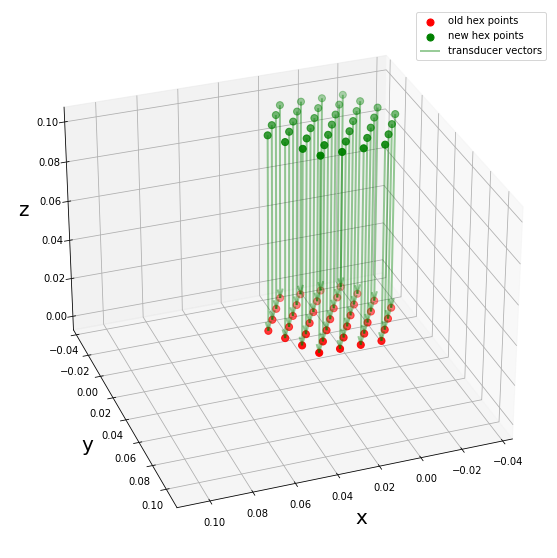

In [4]:
AMM_plane_centre = np.array([0, 0, 0]) # centre point of the AMM plane
tran_plane_centre = np.array([0, 0, 0.1]) # centre point of the new plane

# plane decribing positions of transducers on a hex board. The centre of this plane is [0, 0, 0].
hex_coords = hexagon_diameter_to_coordinates(d=7) 

# rotate and translate these coords to be centred at tran_plane_centre,
# with the normal pointing from here to tran_plane_centre:
rt_hex_coords, tran_plane_normal_vector = rotate_and_translate(hex_coords, AMM_plane_centre, tran_plane_centre)

# plotting
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(hex_coords.T[0], hex_coords.T[1], hex_coords.T[2], s=50,
           c="red", label="old hex points")

ax.scatter(rt_hex_coords.T[0], rt_hex_coords.T[1], rt_hex_coords.T[2], s=50,
           c="green", label="new hex points")

ax.quiver(
          rt_hex_coords.T[0],
          rt_hex_coords.T[1],
          rt_hex_coords.T[2], # <-- starting point of vector
    
          np.ones_like(rt_hex_coords.T[0])*tran_plane_normal_vector[0],
          np.ones_like(rt_hex_coords.T[0])*tran_plane_normal_vector[1],
          np.ones_like(rt_hex_coords.T[0])*tran_plane_normal_vector[2], # <-- directions of vector
    
          color = 'green',
          alpha = .4,
          lw = 2,
          arrow_length_ratio = 0.05,
          label="transducer vectors"
          )

# label plot axes:    
ax.set_xlabel("x", fontsize=20, labelpad=10)
ax.set_ylabel("y", fontsize=20, labelpad=10)
ax.set_zlabel("z", fontsize=20, labelpad=10)

# auto plot scaling and bounding:
scaling = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
ax.auto_scale_xyz(*[[np.min(scaling), np.max(scaling)]]*2)

ax.view_init(30, 70)

ax.legend()

plt.show()